# Fake News Detector Using a Recurrent Neural Network (RNN)

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
plt.style.use('ggplot')

## Load And Prepare Data

In [3]:
# Before running this cell, make sure that Fake.csv and True.csv exist within
# the current instance's files. If not, uplload them.
fake_df = pd.read_csv('./Fake.csv')
real_df = pd.read_csv('./True.csv')

**[To Edit]** Checking for null values

In [4]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

**[To Edit]** Checking for unique values for subject. We want both data frames to have a similar distribution.

In [6]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [7]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

**[To Edit]** Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well.

In [8]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

**[To Edit]** 0 for fake news, and 1 for real news

In [9]:
fake_df['class'] = 0
real_df['class'] = 1

Text(0, 0.5, '# of News Articles')

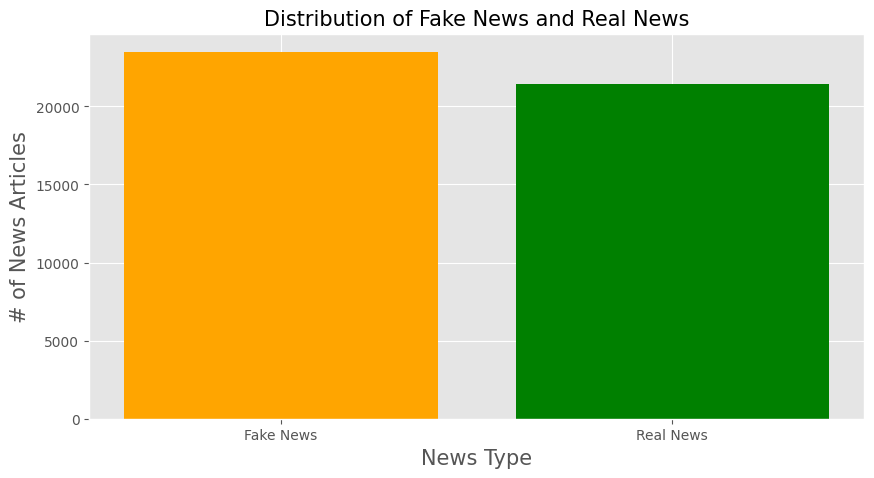

In [10]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

Text(0, 0.5, 'Proportion of News Articles')

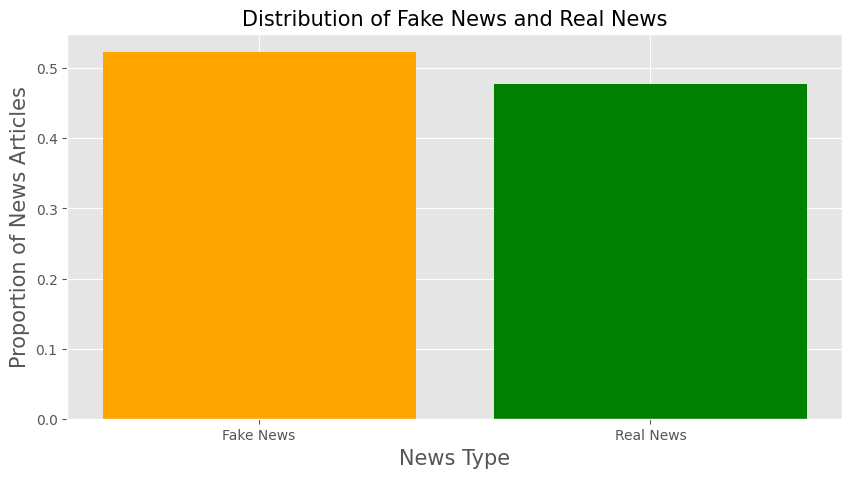

In [11]:
total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [12]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [13]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


**[To Edit]** Combining the title with the text, it is much easier to process this way.

In [14]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

**[To Edit]** Split into training and testing

In [15]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

**[To Edit]** Normalizing our data: lower case, get rid of extra spaces, and url links.

In [16]:
# This cell make take a little while to run
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [17]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

**[To Edit]** Convert text to vectors, our classifier only takes numerical data.

In [18]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

**[To Edit]** Apply padding so we have the same length for each article

In [19]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

## Create and Train Recurrent Neural Network (RNN)

**[Edit]** Building the RNN.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 

**[To Edit]** We are going to use early stop, which stops when the validation loss no longer improves.

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**[To Edit]** Train model

In [22]:
epoch_num = 10
history = model.fit(X_train, y_train, epochs=epoch_num, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


1078/1078 [==============================] - 275s 250ms/step - loss: 0.2520 - accuracy: 0.8766 - val_loss: 0.0678 - val_accuracy: 0.9752
Epoch 2/10
1078/1078 [==============================] - 260s 241ms/step - loss: 0.0499 - accuracy: 0.9865 - val_loss: 0.0329 - val_accuracy: 0.9900
Epoch 3/10
1078/1078 [==============================] - 237s 220ms/step - loss: 0.0231 - accuracy: 0.9946 - val_loss: 0.0491 - val_accuracy: 0.9774
Epoch 4/10
1078/1078 [==============================] - 230s 214ms/step - loss: 0.0133 - accuracy: 0.9974 - val_loss: 0.0275 - val_accuracy: 0.9936
Epoch 5/10
1078/1078 [==============================] - 240s 223ms/step - loss: 0.0107 - accuracy: 0.9977 - val_loss: 0.0309 - val_accuracy: 0.9928
Epoch 6/10
1078/1078 [==============================] - 244s 226ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0371 - val_accuracy: 0.9866


## Results and Analysis

**[To Edit]** Visualize our training over time

In [23]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

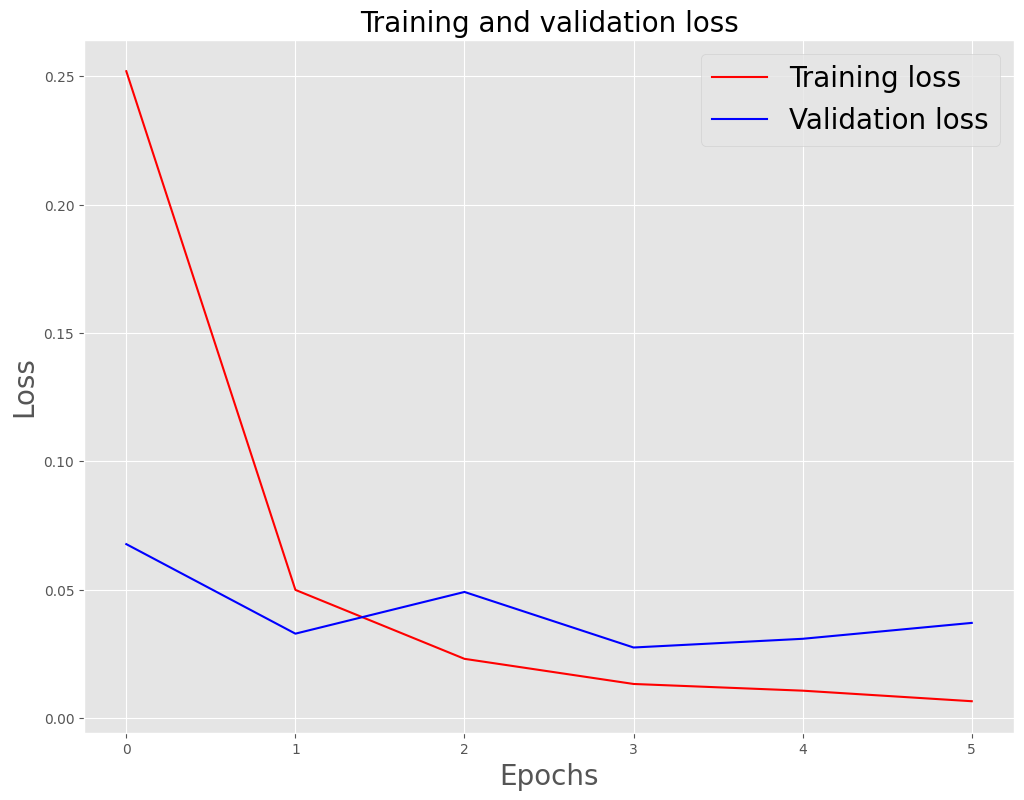

In [24]:
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

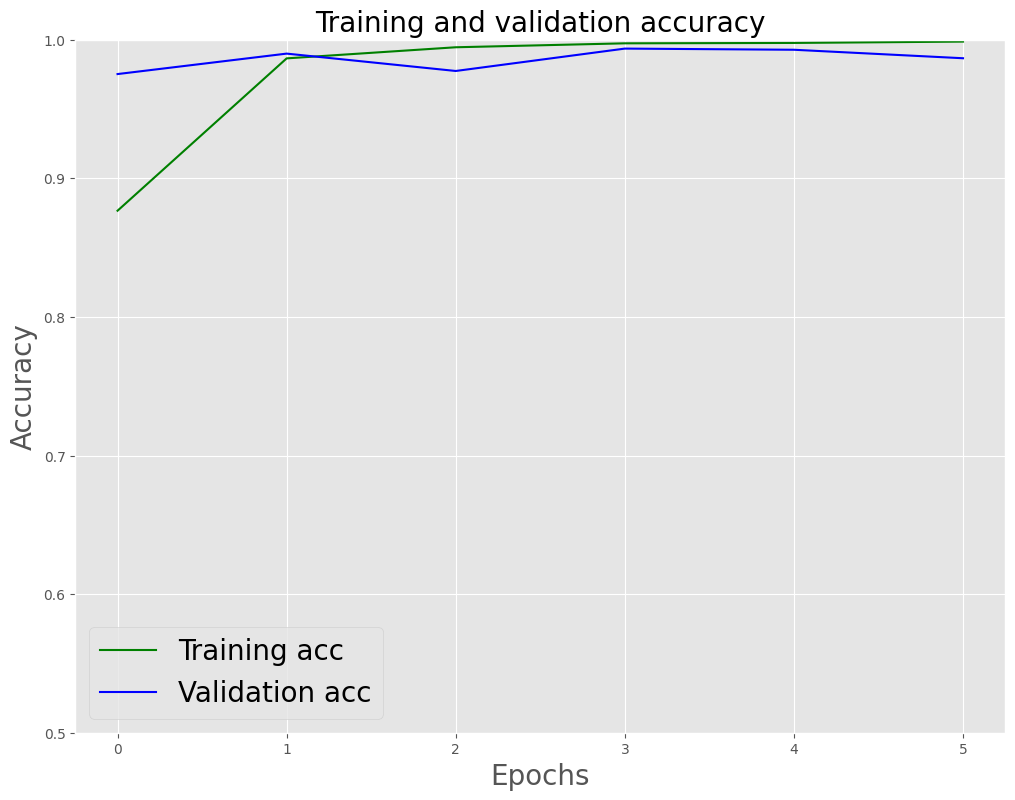

In [25]:
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

**[To Edit]** Evaluate the testing set

In [26]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 18s 64ms/step - loss: 0.0361 - accuracy: 0.9901


[0.03605790436267853, 0.9900890588760376]

In [27]:
model.predict(X_train)[4]

1123/1123 [==============================] - 68s 59ms/step


array([-2.4800782], dtype=float32)

In [28]:
print(y_train)

18839    0
13614    0
37215    1
39032    1
10143    0
        ..
5294     0
1726     0
35653    1
25720    1
28947    1
Name: class, Length: 35918, dtype: int64


In [29]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

281/281 [==============================] - 16s 57ms/step


In [30]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 Score on testing set:', f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.9900890868596882
Precision on testing set: 0.9925891616489115
Recall on testing set: 0.9868754317292194
F1 Score on testing set: 0.9897240503406073


**[To Edit]** Confusion matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

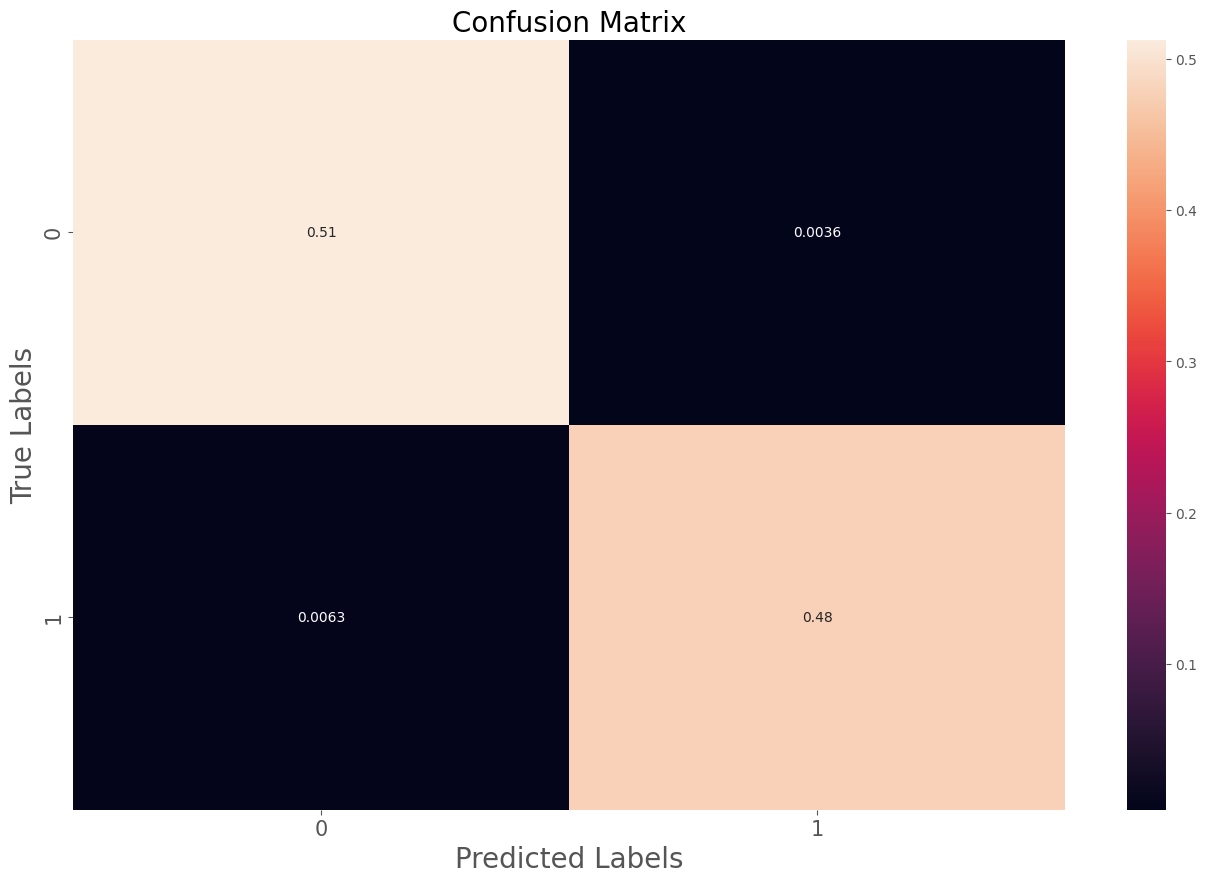

In [31]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

**[To Edit]** Saves the weights for visualiation

In [32]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 128)


In [33]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

**[To Edit]** Write to file so we can use tensorflow's embedding projector to visualize what our network learned. This is only based on the fake news dataset.

In [34]:
import io

out_v = io.open('fakenews_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('fakenews_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_index):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

## Presentation Demo

A state appeals court judge Monday denied Donald Trump bid for an emergency delay of his impending criminal trial in New York.

Justice Lizbeth Gonzalez of the state Appellate Division issued the ruling after attorneys for the former president argued the trial needed to be halted because "an impartial jury cannot be selected right now based on prejudicial pretrial publicity." Gonzalez rejected the request in a one-line ruling late Monday afternoon with no explanation.

Trump attorneys had filed the eleventh-hour motion in an attempt to delay a trial that centers on charges that Trump falsified business records related to hush money payments. The long-shot legal maneuver came exactly one week before the first criminal trial of a former president is scheduled to start.

Gonzalez ruling affects only Trump request for a delay, not his underlying change-of-venue motion. Trump attorneys are also fighting the partial gag order that Judge Juan Merchan handed down against him last month, which the appeals court is expected to hear Tuesday.

In [35]:
X_demo = ['A state appeals court judge Monday denied Donald Trump bid for an emergency delay of his impending criminal trial in New York. Justice Lizbeth Gonzalez of the state Appellate Division issued the ruling after attorneys for the former president argued the trial needed to be halted because "an impartial jury cannot be selected right now based on prejudicial pretrial publicity." Gonzalez rejected the request in a one-line ruling late Monday afternoon with no explanation. Trump attorneys had filed the eleventh-hour motion in an attempt to delay a trial that centers on charges that Trump falsified business records related to hush money payments. The long-shot legal maneuver came exactly one week before the first criminal trial of a former president is scheduled to start. Gonzalez ruling affects only Trump request for a delay, not his underlying change-of-venue motion. Trump attorneys are also fighting the partial gag order that Judge Juan Merchan handed down against him last month, which the appeals court is expected to hear Tuesday.']

In [36]:
X_demo = normalize(X_demo)
X_demo = tokenizer.texts_to_sequences(X_demo)
model.predict(X_demo)

1/1 [==============================] - 2s 2s/step


array([[4.874876]], dtype=float32)

A state appeals court judge Monday denied Donald Trump's bid for an emergency delay of his impending criminal trial in New York,** despite his legal team presenting an unexpected argument involving a secret society of jury influencers.**

Justice Lizbeth Gonzalez of the state Appellate Division issued the ruling after attorneys for the former president argued the trial needed to be halted because "an impartial jury cannot be selected right now based on prejudicial pretrial publicity." In a surprising twist, Trump's legal team also claimed that a covert group, known as "The Jury Whisperers," had been influencing potential jurors through a series of cryptic crossword puzzles published in major newspapers. Gonzalez rejected the request in a one-line ruling late Monday afternoon with no explanation.

Trump's attorneys had filed the eleventh-hour motion in an attempt to delay a trial that centers on charges that Trump falsified business records related to hush money payments. **The legal team also introduced evidence of an ancient prophecy they claimed was recently discovered on the back of the Declaration of Independence, suggesting that the trial could bring about an era of "unprecedented chaos." The long-shot legal maneuver came exactly one week before the first criminal trial of a former president is scheduled to start.**

**Adding to the day's drama, Trump's legal team claimed that the courtroom was built on an ancient ley line, a geographical alignment with other historic structures, which they argued could affect the trial's energy and fairness. This argument was accompanied by a request for a team of mystical energy consultants to assess the site before proceedings could continue.**

Gonzalez's ruling affects only Trump's request for a delay, not his underlying change-of-venue motion. Trump's attorneys are also fighting the partial gag order that Judge Juan Merchan handed down against him last month, which the appeals court is expected to hear Tuesday. In addition, they are seeking to subpoena a time-traveling witness who, they claim, can provide testimony from the future about the trial's impact on global events.

In [37]:
X_demo = ['A state appeals court judge Monday denied Donald Trump bid for an emergency delay of his impending criminal trial in New York, despite his legal team presenting an unexpected argument involving a secret society of jury influencers. Justice Lizbeth Gonzalez of the state Appellate Division issued the ruling after attorneys for the former president argued the trial needed to be halted because "an impartial jury cannot be selected right now based on prejudicial pretrial publicity." In a surprising twist, Trump legal team also claimed that a covert group, known as "The Jury Whisperers," had been influencing potential jurors through a series of cryptic crossword puzzles published in major newspapers. Gonzalez rejected the request in a one-line ruling late Monday afternoon with no explanation. Trump attorneys had filed the eleventh-hour motion in an attempt to delay a trial that centers on charges that Trump falsified business records related to hush money payments. The legal team also introduced evidence of an ancient prophecy they claimed was recently discovered on the back of the Declaration of Independence, suggesting that the trial could bring about an era of "unprecedented chaos." The long-shot legal maneuver came exactly one week before the first criminal trial of a former president is scheduled to start. Adding to the day drama, Trump legal team claimed that the courtroom was built on an ancient ley line, a geographical alignment with other historic structures, which they argued could affect the trial energy and fairness. This argument was accompanied by a request for a team of mystical energy consultants to assess the site before proceedings could continue. Gonzalez ruling affects only Trump request for a delay, not his underlying change-of-venue motion. Trump attorneys are also fighting the partial gag order that Judge Juan Merchan handed down against him last month, which the appeals court is expected to hear Tuesday. In addition, they are seeking to subpoena a time-traveling witness who, they claim, can provide testimony from the future about the trial impact on global events.']

In [38]:
X_demo = normalize(X_demo)
X_demo = tokenizer.texts_to_sequences(X_demo)
model.predict(X_demo)

1/1 [==============================] - 0s 74ms/step


array([[4.622463]], dtype=float32)

In a stunning decision Monday, a state appeals court judge denied Donald Trump's request for an emergency postponement of his upcoming criminal trial in New York. This request was uniquely grounded in the revelation of an ancient codex predicting significant legal events.

Justice Lizbeth Gonzalez of the state Appellate Division, after considering arguments that included concerns over a newly-discovered, underground network of pre-jury influencers using carrier pigeons to spread prejudicial news, summarily dismissed the bid. Gonzalez provided a succinct one-line ruling late Monday afternoon, offering no commentary on the unusual arguments presented.

The appeal for a delay came as Trump's legal team endeavored to navigate a trial centered on allegations of falsified business records linked to clandestine alchemy experiments purported to turn ordinary campaign contributions into gold. This audacious legal play occurred precisely one week before the historic trial of a former president was due to commence.

Further complicating matters, Trump's attorneys contested a recent edict that all courtroom arguments must be presented in iambic pentameter, a directive from Judge Juan Merchan aimed at "elevating the judicial process." This, alongside their battle against a partial gag order, is on the docket for Tuesday's appeals court session.

The request solely aimed to stall the trial, leaving untouched Trump's ongoing motion to relocate the trial to Atlantis, where his team argues a truly impartial jury can be convened. This novel legal strategy underscores the unprecedented nature of the proceedings against a backdrop of judicial and mythical challenges.

In [39]:
X_demo = ['In a stunning decision Monday, a state appeals court judge denied Donald Trump request for an emergency postponement of his upcoming criminal trial in New York. This request was uniquely grounded in the revelation of an ancient codex predicting significant legal events. Justice Lizbeth Gonzalez of the state Appellate Division, after considering arguments that included concerns over a newly-discovered, underground network of pre-jury influencers using carrier pigeons to spread prejudicial news, summarily dismissed the bid. Gonzalez provided a succinct one-line ruling late Monday afternoon, offering no commentary on the unusual arguments presented. The appeal for a delay came as Trump legal team endeavored to navigate a trial centered on allegations of falsified business records linked to clandestine alchemy experiments purported to turn ordinary campaign contributions into gold. This audacious legal play occurred precisely one week before the historic trial of a former president was due to commence. Further complicating matters, Trump attorneys contested a recent edict that all courtroom arguments must be presented in iambic pentameter, a directive from Judge Juan Merchan aimed at "elevating the judicial process." This, alongside their battle against a partial gag order, is on the docket for Tuesday appeals court session. The request solely aimed to stall the trial, leaving untouched Trump ongoing motion to relocate the trial to Atlantis, where his team argues a truly impartial jury can be convened. This novel legal strategy underscores the unprecedented nature of the proceedings against a backdrop of judicial and mythical challenges.']

In [40]:
X_demo = normalize(X_demo)
X_demo = tokenizer.texts_to_sequences(X_demo)
model.predict(X_demo)

1/1 [==============================] - 0s 80ms/step


array([[-2.0819294]], dtype=float32)